In [1]:
import matplotlib.pyplot as plt
% matplotlib inline
import pylab
import os
import numpy as np
#import seaborn as sns
import seaborn as sns
sns.set_style("white")
color_list = sns.color_palette("muted")
blue = color_list[0]
green = color_list[1]
red = color_list[2]

In [2]:
def load_performance_data(filename):
    try:
        import pandas as pd
        return pd.read_csv(filename)
    except:
        print(filename)
        return None
def load_average_return(filename, label = 'AverageReturn'):
    data = load_performance_data(filename)
    if data is not None:
        return data[label]
    else:
        return None

In [3]:
def get_filename_list(root_dir = "./../exp_log/", **kwargs):
    filename_list = os.listdir(root_dir)
    if 'algo' in kwargs:
        algorithm_name = kwargs['algo']
        filename_list = [f for f in filename_list if f.split('seed')[0][:-1] == algorithm_name]
    if 'seed' in kwargs:
        random_seed = kwargs['seed']
        filename_list = [f for f in filename_list if int(f.split('=')[1].strip().split('_')[0]) == random_seed]
    if 'env' in kwargs:
        env = kwargs['env']
        filename_list = [f for f in filename_list if 'env'.join('_'.join(f.split('_')[:-2]).split('env')[1:])[1:] == env]
    filename_list = [os.path.join(root_dir, filename) for filename in filename_list]
    return filename_list
def get_multi_performance(root_dir="./../exp_log/",label = "AverageReturn", long_episode = False, **kwargs):
    filename_list = get_filename_list(root_dir, **kwargs)
    performance = [load_average_return(os.path.join(filename, "progress.csv"), label = label) for filename in filename_list]
    if long_episode:
        for i in range(len(performance)):
            performance[i] = [performance[i][j*16] for j in range(len(performance[i])/16)]
    env_name = kwargs['env']
    if env_name == 'cartpole':
        length = 50 
    elif env_name == 'mountain_car':
        length = 50
    else:
        length = 1000
    min_length = min(length, np.min([len(i) for i in performance]))
    performance = [item[:min_length] for item in performance]
    performance = np.array(performance)
    performance_mean = np.mean(performance, axis = 0)
    performance_std = np.std(performance, axis = 0)
    
    performance_threshold = np.max(performance_mean)
    performance_threshold = performance_threshold - 0.05 * np.abs(performance_threshold)
    import pprint
    pprint.pprint(kwargs)
    print(np.argmax(performance_mean > performance_threshold),"{:.2f}".format(np.max(performance_mean)))
    return performance_mean, performance_std

In [4]:
def compare_algorihtms(algorithm_list = None, 
                       env_list = ['cartpole_swing_up','double_pendulum_env','mountain_car', 'cartpole','swim','ant'][:2],
                       seed =[1, 12, 123, 1234, 12345],
                       root_dir = None,
                      label = "AverageReturn", label_list = None, colors = None):
    env_map = {"cartpole_swing_up": "Cartpole Swing Up",
               "double_pendulum_env": "Double Pendulum",
               "mountain_car" : "Mountain Car",
               "cartpole": "CartPole"}
    if label_list is None:
        label_list = [i for i in algorithm_list]
    if root_dir is None:
        root_idr = ["./../exp_log/" for _ in range(len(algorithm_list))]
    if len(env_list)==4:
        x, y = 1, 4
    elif len(env_list) == 3:
        x, y = 1, 3
    else:
        x, y = 1, 2
    for env_id, env in enumerate(env_list):
        if not ( x * y == 1):
            plt.subplot(x, y, env_id + 1)
        for id, (algorithm, root, labelitem) in enumerate(zip(algorithm_list, root_dir, label_list)):
            performance_mean, performance_std = get_multi_performance(algo=algorithm, env=env, root_dir=root, label = label, long_episode=(id==-1))
            if colors is None:
                plt.plot(range(len(performance_mean)), performance_mean, label = labelitem, linewidth=3.0)
            else:
                plt.plot(range(len(performance_mean)), performance_mean, label = labelitem, linewidth = 3.0, color = colors[id])
            plt.fill_between(range(len(performance_mean)), performance_mean - performance_std, performance_mean + performance_std, alpha= 0.3)
            #plt.xlim([-5, 1000])
        plt.title("{:}".format(env_map[env]), fontsize=20)
        plt.legend()

In [5]:
######################## FOR PAPER ########################

{'algo': 'multi_REINFORCE_baseline', 'env': 'cartpole_swing_up'}
(728, '234.30')
{'algo': 'multi_REINFORCE_stein#16_temp=10.0', 'env': 'cartpole_swing_up'}
(509, '405.17')
{'algo': 'multi_REINFORCE_baseline', 'env': 'double_pendulum_env'}
(33, '-910.60')
{'algo': 'multi_REINFORCE_stein#16_temp=10.0', 'env': 'double_pendulum_env'}
(649, '-341.07')


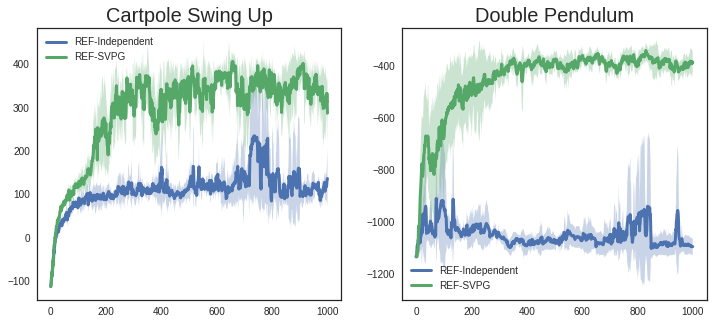

In [8]:
pylab.rcParams['figure.figsize'] = (12, 5)
compare_algorihtms(algorithm_list=['multi_REINFORCE_baseline', 'multi_REINFORCE_stein#16_temp=10.0'],
                   root_dir = ["./../exp_log", "../exp_log/"],
                    label_list = ["REF-Independent", "REF-SVPG"])